In [11]:
from src.utils.quantization import export_and_quantize_dinov2, load_input, load_model, export_dinov2, load_input_fixed, unflatten_detectron2_boxes, unflatten_detectron2_instances
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import matplotlib.pyplot as plt
from demo import VisualizationDemo
from detectron2.data.detection_utils import read_image
from copy import copy
import torch
import torchvision.transforms as T
import torch_tensorrt

import nvidia_dlprof_pytorch_nvtx
nvidia_dlprof_pytorch_nvtx.init()

Initializing NVTX monkey patches


  return isinstance(object, types.MethodType)

  return isinstance(object, types.FunctionType)

  return isinstance(object, type)

  return isinstance(object, types.BuiltinFunctionType)



Done with NVTX monkey patching


In [6]:

# model = torch.jit.load("trt.ts")
model = torch.export.load("trt.ep").module()

ERROR: [Torch-TensorRT] - linux_x86_64
ERROR: [Torch-TensorRT] - Platform constructor: linux_x86_64
  getattr_node = gm.graph.get_attr(lifted_node)

  warnings.warn(f'Node {node} target {node.target} {atom} of {seen_qualname} does '



In [7]:
image_path = "artifacts/ams.jpg"
# image_path = "artifacts/white.jpg"
img, example_kwargs = load_input_fixed(image_path, height=512, width=512)

In [14]:
with torch.autograd.profiler.emit_nvtx():
    with torch.no_grad():
        outputs = model(example_kwargs["images"].cuda())

Generating '/tmp/nsys-report-e63e.qdstrm'
[1/1] [========================100%] 012_trt_model_validation_2024-09-24T17:31:48.nsys-rep
Generated:
    /teamspace/studios/this_studio/notebooks/012_trt_model_validation_2024-09-24T17:31:48.nsys-rep


Generating '/tmp/nsys-report-3f05.qdstrm'
[1/1] [========================100%] 012_trt_model_validation_2024-09-24T17:30:20.nsys-rep
Generated:
    /teamspace/studios/this_studio/notebooks/012_trt_model_validation_2024-09-24T17:30:20.nsys-rep


In [9]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True, profile_memory=True) as prof:
    with record_function("model_inference"):
        with torch.no_grad():
            outputs = model(example_kwargs["images"].cuda())

INFO:2024-09-24 17:27:53 38957:38957 init.cpp:181] If you see CUPTI_ERROR_INSUFFICIENT_PRIVILEGES, refer to https://developer.nvidia.com/nvidia-development-tools-solutions-err-nvgpuctrperm-cupti


In [11]:
print(prof.key_averages())#.table(sort_by="cuda_time_total", row_limit=10))
prof.export_chrome_trace("trace.json")


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         0.56%     629.933us         5.56%       6.254ms       6.254ms       0.000us         0.00%     110.109ms     110.109ms           0 b           0 b           0 b      -3.01 M

In [7]:
%%time
with torch.no_grad():
    for _ in range(30):
        outputs = model(example_kwargs["images"].cuda())

CPU times: user 3.44 s, sys: 562 µs, total: 3.44 s
Wall time: 3.44 s


In [8]:
def filter_predictions_with_confidence(predictions, confidence_threshold=0.5):
    if "instances" in predictions:
        preds = predictions["instances"]
        keep_idxs = preds.scores > confidence_threshold
        predictions = copy(predictions)  # don't modify the original
        predictions["instances"] = preds[keep_idxs]
    return predictions

In [9]:
def unflatten_repr(obj):
    obj = dict(pred_boxes=obj[0], scores=obj[1], pred_classes=obj[2])
    obj = dict(instances=[(512, 512), obj])
    obj["instances"][1]["pred_boxes"] = unflatten_detectron2_boxes(
        [obj["instances"][1]["pred_boxes"]], None
    )
    obj["instances"] = unflatten_detectron2_instances(obj["instances"], None)
    return obj

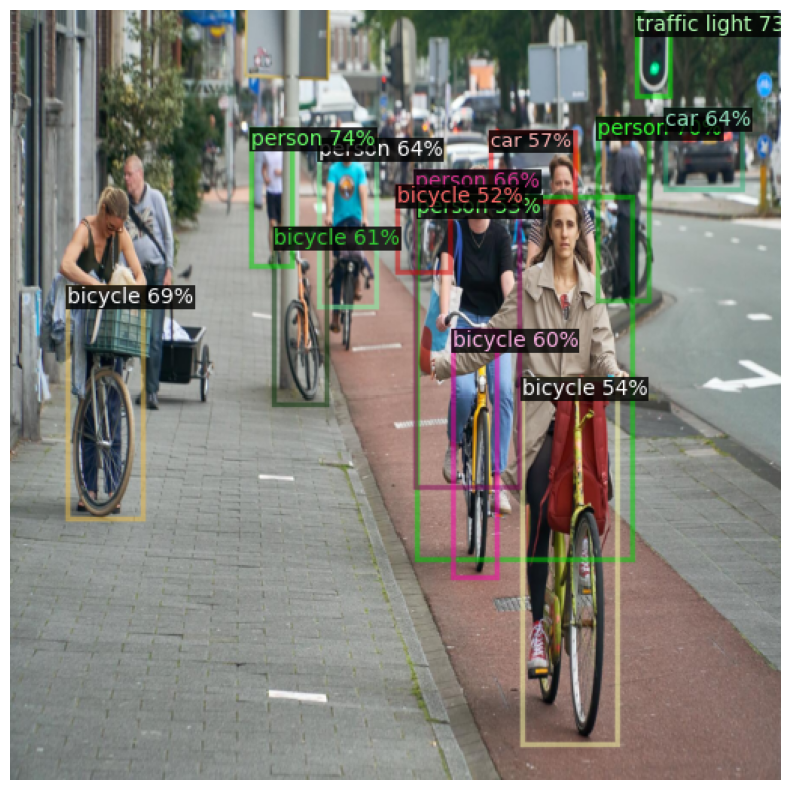

In [10]:
outputs = unflatten_repr(outputs)
pred = filter_predictions_with_confidence(outputs, confidence_threshold=0.5)
v = Visualizer(img, MetadataCatalog.get("coco_2017_val"))
v = v.draw_instance_predictions(pred["instances"].to("cpu"))

# Display the results
plt.figure(figsize=(14, 10))
plt.imshow(v.get_image()[:, :, ::-1])
plt.axis("off")
plt.show()